In [59]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, 
    TimeSeriesSplit, validation_curve
)
from sklearn.exceptions import DataConversionWarning, UndefinedMetricWarning
from sklearn.externals import joblib
from sklearn.linear_model import SGDClassifier

from scipy import sparse

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
%config InlineBackend.figure_format = 'retina'

In [60]:
Dtrain = pd.read_csv('Dtrain.csv')
Dtest = pd.read_csv('Dtest.csv')

In [61]:
def get_summary_grid(grid):
    parms = list(grid.param_grid.keys())
    columns = ['Iter #']
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in grid.param_grid.keys():
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[1:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
    for k, v in grid.param_grid.items():
        items *= len(v)
    df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [62]:
def get_summary_randomized(grid):
    parms = list(grid.param_distributions.keys())
    columns = []
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in parms:
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[0:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
#     for k, v in grid.param_distributions.items():
#         items *= len(v)
#     df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [63]:
sclr = StandardScaler(copy=True)
sclr2 = StandardScaler(with_mean=False)

In [64]:
tscv = TimeSeriesSplit(n_splits=5)

## Bag of Words

### Loading the data

In [65]:
Dtrain_bow = sparse.load_npz('BOW_train.npz')
Dtest_bow = sparse.load_npz('BOW_test.npz')

In [66]:
yTrain_bow = Dtrain.Polarity
yTest_bow = Dtest.Polarity

### Scaling the data

In [67]:
Dtrain_scaled_bow = sclr2.fit_transform(Dtrain_bow)
Dtest_scaled_bow = sclr2.fit_transform(Dtest_bow)

In [68]:
params = {
    'alpha': np.logspace(-6, 10, 50)
}

In [69]:
estimator = SGDClassifier(random_state=42)

In [70]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8)

In [71]:
features = Dtrain_scaled_bow
labels = yTrain_bow.apply(lambda x: 1 if x == 'positive' else 0).values

In [72]:
grid.fit(features, labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] alpha=1e-06 .....................................................
[CV] alpha=1e-06 .....................................................
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.4s
[CV] alpha=1e-06 .....................................................
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.5s
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] ..................... alpha=2.1209508879201924e-06, total=   0.4s
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] alpha=4.49

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.0s


[CV] alpha=9.102981779915228e-05 .....................................
[CV] alpha=9.102981779915228e-05 .....................................
[CV] ...................... alpha=4.291934260128778e-05, total=   1.6s
[CV] ...................... alpha=4.291934260128778e-05, total=   1.4s
[CV] alpha=9.102981779915228e-05 .....................................
[CV] alpha=9.102981779915228e-05 .....................................
[CV] ..................... alpha=2.0235896477251556e-05, total=   3.0s
[CV] ...................... alpha=9.102981779915228e-05, total=   1.2s
[CV] alpha=9.102981779915228e-05 .....................................
[CV] ...................... alpha=4.291934260128778e-05, total=   2.1s
[CV] alpha=0.00019306977288832496 ....................................
[CV] alpha=0.00019306977288832496 ....................................
[CV] ...................... alpha=9.102981779915228e-05, total=   1.8s
[CV] ...................... alpha=9.102981779915228e-05, total=   1.5s
[CV] a

[CV] ........................ alpha=0.16768329368110066, total=   1.6s
[CV] alpha=0.35564803062231287 .......................................
[CV] ........................ alpha=0.35564803062231287, total=   1.2s
[CV] alpha=0.35564803062231287 .......................................
[CV] alpha=0.7543120063354607 ........................................
[CV] ........................ alpha=0.35564803062231287, total=   1.3s
[CV] alpha=0.7543120063354607 ........................................
[CV] ........................ alpha=0.16768329368110066, total=   1.9s
[CV] alpha=0.7543120063354607 ........................................
[CV] ........................ alpha=0.35564803062231287, total=   1.5s
[CV] alpha=0.7543120063354607 ........................................
[CV] alpha=0.7543120063354607 ........................................
[CV] ......................... alpha=0.7543120063354607, total=   1.1s
[CV] ........................ alpha=0.35564803062231287, total=   1.6s
[CV] a

[CV] alpha=2947.0517025518097 ........................................
[CV] ......................... alpha=1389.4954943731361, total=   2.3s
[CV] .......................... alpha=655.1285568595496, total=   3.0s
[CV] alpha=2947.0517025518097 ........................................
[CV] ......................... alpha=2947.0517025518097, total=   1.6s
[CV] ......................... alpha=1389.4954943731361, total=   2.1s
[CV] alpha=2947.0517025518097 ........................................
[CV] alpha=6250.5519252739505 ........................................
[CV] alpha=6250.5519252739505 ........................................
[CV] ......................... alpha=2947.0517025518097, total=   1.7s
[CV] alpha=6250.5519252739505 ........................................
[CV] ......................... alpha=1389.4954943731361, total=   3.2s
[CV] ......................... alpha=6250.5519252739505, total=   1.0s


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   55.7s


[CV] alpha=6250.5519252739505 ........................................
[CV] ......................... alpha=1389.4954943731361, total=   3.2s
[CV] alpha=6250.5519252739505 ........................................
[CV] ......................... alpha=2947.0517025518097, total=   2.6s
[CV] alpha=13257.113655901054 ........................................
[CV] ......................... alpha=6250.5519252739505, total=   2.2s
[CV] alpha=13257.113655901054 ........................................
[CV] ......................... alpha=2947.0517025518097, total=   2.5s
[CV] alpha=13257.113655901054 ........................................
[CV] ......................... alpha=6250.5519252739505, total=   2.2s
[CV] ......................... alpha=2947.0517025518097, total=   3.2s
[CV] ......................... alpha=13257.113655901054, total=   1.4s
[CV] alpha=13257.113655901054 ........................................
[CV] alpha=13257.113655901054 ........................................
[CV] a

[CV] alpha=51794746.79231202 .........................................
[CV] alpha=51794746.79231202 .........................................
[CV] ......................... alpha=11513953.993264433, total=   2.8s
[CV] .......................... alpha=24420530.94548645, total=   2.0s
[CV] alpha=51794746.79231202 .........................................
[CV] alpha=51794746.79231202 .........................................
[CV] .......................... alpha=51794746.79231202, total=   1.1s
[CV] alpha=51794746.79231202 .........................................
[CV] alpha=109854114.19875573 ........................................
[CV] .......................... alpha=51794746.79231202, total=   1.3s
[CV] alpha=109854114.19875573 ........................................
[CV] .......................... alpha=24420530.94548645, total=   2.0s
[CV] alpha=109854114.19875573 ........................................
[CV] .......................... alpha=24420530.94548645, total=   2.7s
[CV] a

[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:  1.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'alpha': array([1.00000e-06, 2.12095e-06, 4.49843e-06, 9.54095e-06, 2.02359e-05,
       4.29193e-05, 9.10298e-05, 1.93070e-04, 4.09492e-04, 8.68511e-04,
       1.84207e-03, 3.90694e-03, 8.28643e-03, 1.75751e-02, 3.72759e-02,
       7.90604e-02, 1.67683e-01, 3.55648e-01, 7.54312e-01, 1.59... 1.09854e+08, 2.32995e+08,
       4.94171e+08, 1.04811e+09, 2.22300e+09, 4.71487e+09, 1.00000e+10])},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'f1', 'recall', 'accuracy

In [73]:
get_summary_grid(grid).sort_values('test_f1', ascending=False).head()

,Iter #,train_f1,test_f1,train_recall,test_recall,train_accuracy,test_accuracy,train_precision,test_precision,fit_time,score_time,alpha
16,17,0.973787,0.938407,0.993870,0.975127,0.953471,0.892137,0.954514,0.904352,1.379927,0.101422,0.167683
15,16,0.977299,0.937718,0.992233,0.965611,0.959932,0.891907,0.962820,0.911392,1.483293,0.150426,0.079060
17,18,0.968775,0.936555,0.995518,0.983576,0.944171,0.887717,0.943446,0.893827,1.584341,0.143774,0.355648
14,15,0.979497,0.934635,0.990288,0.954907,0.963984,0.887434,0.968951,0.915207,1.813858,0.129305,0.037276
18,19,0.961320,0.931806,0.997283,0.991434,0.930151,0.877740,0.927882,0.878948,1.490148,0.155878,0.754312


In [74]:
train_scores, test_scores = validation_curve(
    estimator, features, labels, param_name="alpha", param_range=params['alpha'],
    cv=tscv, scoring="f1", n_jobs=8)

In [75]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

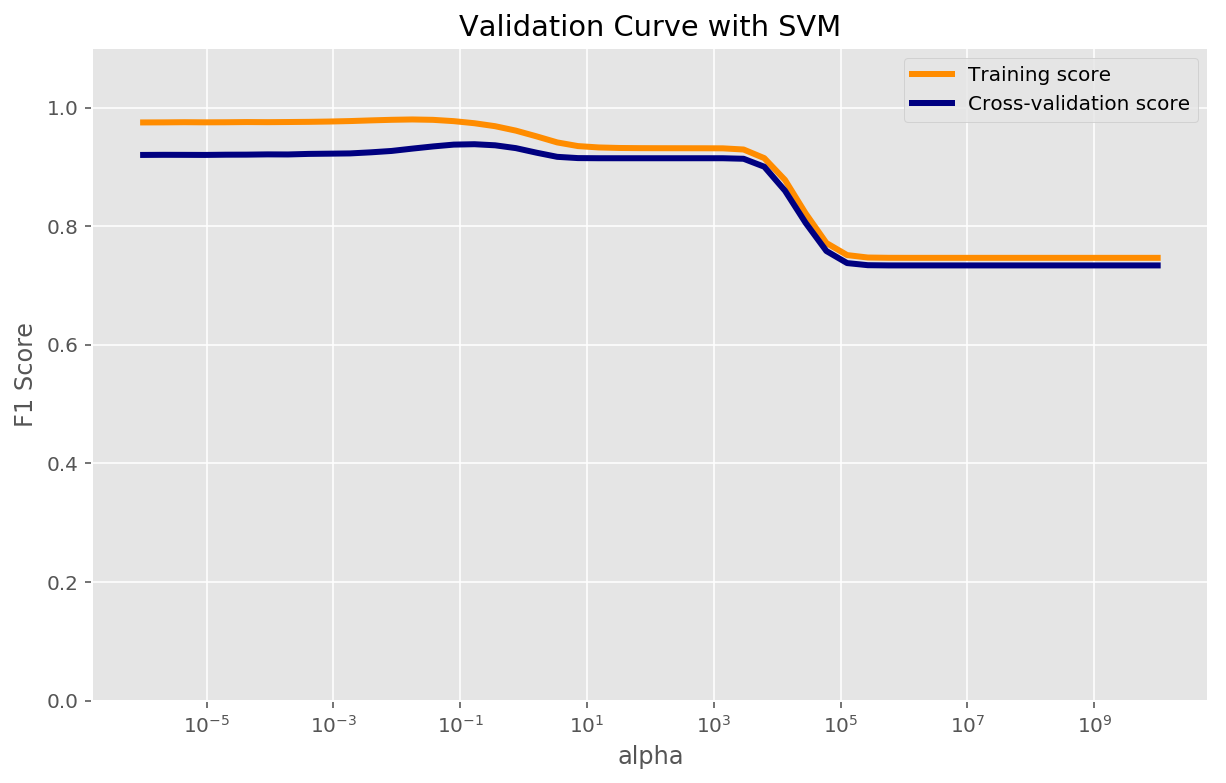

In [76]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("Validation Curve with SVM")
plt.xlabel("alpha")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
lw = 3
plt.semilogx(params['alpha'], train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.semilogx(params['alpha'], test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [77]:
grid.best_estimator_

SGDClassifier(alpha=0.16768329368110066, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

### Saving the best estimator

In [78]:
joblib.dump(grid.best_estimator_, 'bow_best.model')

['bow_best.model']

## TFIDF

### Loading the data

In [79]:
Dtrain_tfidf = sparse.load_npz('tfidf_train.npz')
Dtest_tfidf = sparse.load_npz('tfidf_test.npz')

In [80]:
yTrain_tfidf = Dtrain.Polarity
yTest_tfidf = Dtest.Polarity

### Scaling the data

In [81]:
Dtrain_scaled_tfidf = sclr2.fit_transform(Dtrain_tfidf)
Dtest_scaled_tfidf = sclr2.fit_transform(Dtest_tfidf)

In [82]:
params = {
    'alpha': np.logspace(-6, 10, 500)
}

In [83]:
estimator = SGDClassifier(random_state=42)

In [84]:
grid = RandomizedSearchCV(estimator=estimator,
                    param_distributions=params,
                    n_iter=50,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8)

In [85]:
features = Dtrain_scaled_tfidf
labels = yTrain_tfidf.apply(lambda x: 1 if x == 'positive' else 0).values

In [86]:
grid.fit(features, labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] alpha=95490445.57518038 .........................................
[CV] alpha=95490445.57518038 .........................................
[CV] alpha=95490445.57518038 .........................................
[CV] alpha=95490445.57518038 .........................................
[CV] .......................... alpha=95490445.57518038, total=   0.6s
[CV] alpha=95490445.57518038 .........................................
[CV] alpha=89.51664721378283 .........................................
[CV] .......................... alpha=95490445.57518038, total=   0.6s
[CV] alpha=89.51664721378283 .........................................
[CV] alpha=89.51664721378283 .........................................
[CV] alpha=89.51664721378283 .........................................
[CV] alpha=89.51664721378283 .........................................
[CV] .......................... alpha=89.51664721378283, total=   0.7s
[CV] alpha=7651

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   10.1s


[CV] alpha=9.862521794868784e-06 .....................................
[CV] .......................... alpha=71.73174944465597, total=   1.7s
[CV] ...................... alpha=9.862521794868784e-06, total=   1.3s
[CV] alpha=9.862521794868784e-06 .....................................
[CV] alpha=9.862521794868784e-06 .....................................
[CV] .......................... alpha=71.73174944465597, total=   1.8s
[CV] ......................... alpha=0.7939617845382275, total=   3.3s
[CV] alpha=160106446.1318311 .........................................
[CV] ...................... alpha=9.862521794868784e-06, total=   1.8s
[CV] alpha=160106446.1318311 .........................................
[CV] alpha=160106446.1318311 .........................................
[CV] ...................... alpha=9.862521794868784e-06, total=   1.5s
[CV] alpha=160106446.1318311 .........................................
[CV] alpha=160106446.1318311 .........................................
[CV] .

[CV] alpha=0.0020072673035625684 .....................................
[CV] alpha=2380967.7173803486 ........................................
[CV] ...................... alpha=0.0020072673035625684, total=   1.6s
[CV] alpha=2380967.7173803486 ........................................
[CV] alpha=2380967.7173803486 ........................................
[CV] ...................... alpha=2.611161100917462e-06, total=   2.5s
[CV] ......................... alpha=2380967.7173803486, total=   0.8s
[CV] alpha=2380967.7173803486 ........................................
[CV] ...................... alpha=0.0020072673035625684, total=   1.9s
[CV] ...................... alpha=0.0020072673035625684, total=   1.4s
[CV] alpha=2380967.7173803486 ........................................
[CV] alpha=526.5539630332755 .........................................
[CV] alpha=526.5539630332755 .........................................
[CV] alpha=526.5539630332755 .........................................
[CV] .

[CV] ...................... alpha=5.882190401699956e-06, total=   2.8s
[CV] alpha=5.8013231038333784e-05 ....................................
[CV] ......................... alpha=489.07870941395896, total=   1.6s
[CV] ...................... alpha=5.882190401699956e-06, total=   3.7s
[CV] alpha=5.8013231038333784e-05 ....................................
[CV] alpha=3303985069.871855 .........................................
[CV] ......................... alpha=489.07870941395896, total=   2.6s
[CV] alpha=3303985069.871855 .........................................
[CV] ..................... alpha=5.8013231038333784e-05, total=   1.6s


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   55.3s


[CV] alpha=3303985069.871855 .........................................
[CV] ..................... alpha=5.8013231038333784e-05, total=   1.5s
[CV] alpha=3303985069.871855 .........................................
[CV] .......................... alpha=3303985069.871855, total=   0.9s
[CV] alpha=3303985069.871855 .........................................
[CV] alpha=0.019796717529513327 ......................................
[CV] .......................... alpha=3303985069.871855, total=   1.2s
[CV] ..................... alpha=5.8013231038333784e-05, total=   2.2s
[CV] alpha=0.019796717529513327 ......................................
[CV] ..................... alpha=5.8013231038333784e-05, total=   2.2s
[CV] alpha=0.019796717529513327 ......................................
[CV] alpha=0.019796717529513327 ......................................
[CV] ....................... alpha=0.019796717529513327, total=   1.0s
[CV] alpha=0.019796717529513327 ......................................
[CV] a

[CV] alpha=49134072.862963565 ........................................
[CV] .......................... alpha=338.1100782480682, total=   3.6s
[CV] .......................... alpha=22.01331107493028, total=   2.7s
[CV] alpha=49134072.862963565 ........................................
[CV] ......................... alpha=49134072.862963565, total=   1.5s
[CV] alpha=49134072.862963565 ........................................
[CV] .......................... alpha=26353.70519267393, total=   2.7s
[CV] .......................... alpha=26353.70519267393, total=   2.6s
[CV] alpha=49134072.862963565 ........................................
[CV] .......................... alpha=22.01331107493028, total=   3.7s
[CV] ......................... alpha=49134072.862963565, total=   1.8s
[CV] alpha=421.9398080805024 .........................................
[CV] ......................... alpha=49134072.862963565, total=   1.7s
[CV] alpha=421.9398080805024 .........................................
[CV] .

[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:  1.6min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          error_score='raise',
          estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=8,
          param_distributions={'alpha': array([1.00000e-06, 1.07662e-06, ..., 9.28829e+09, 1.00000e+10])},
          pre_dispatch='2*n_jobs', random_state=None, refit='f1',
          return_train_score=True,
          scoring={'f1', 'recall', 'accuracy', 'precision'}, verbose=2)

In [87]:
get_summary_randomized(grid).sort_values('test_f1', ascending=False).head()

,train_f1,test_f1,train_recall,test_recall,train_accuracy,test_accuracy,train_precision,test_precision,fit_time,score_time,alpha
9,0.975499,0.934408,0.993031,0.967276,0.956637,0.885546,0.958601,0.903707,1.858950,0.160801,0.134977
32,0.978796,0.931512,0.990242,0.952572,0.962727,0.881921,0.967628,0.911371,1.844389,0.128071,0.055653
47,0.979239,0.930715,0.989432,0.949765,0.963559,0.880800,0.969270,0.912422,1.668682,0.199174,0.044596
21,0.979017,0.930537,0.989675,0.949688,0.963146,0.880471,0.968601,0.912156,1.840249,0.164441,0.048013
4,0.959830,0.927637,0.998196,0.991810,0.927282,0.869661,0.924356,0.871288,1.824384,0.160100,0.793962


In [95]:
train_scores, test_scores = validation_curve(
    estimator, features, labels, param_name="alpha", param_range=params['alpha'],
    cv=tscv, scoring="f1", n_jobs=8)

In [96]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

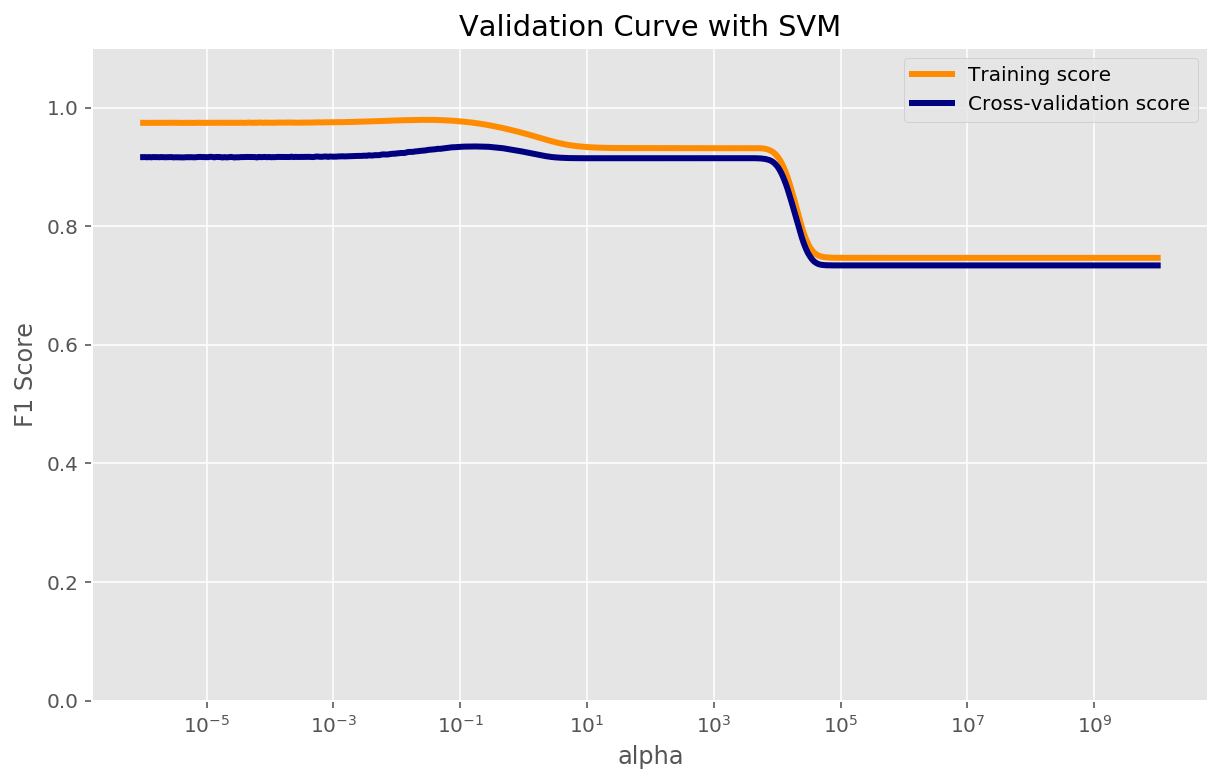

In [97]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("Validation Curve with SVM")
plt.xlabel("alpha")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
lw = 3
plt.semilogx(params['alpha'], train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.semilogx(params['alpha'], test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [98]:
grid.best_estimator_

SGDClassifier(alpha=0.13497723302339418, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

### Saving the best estimator

In [99]:
joblib.dump(grid.best_estimator_, 'tfidf_best.model')

['tfidf_best.model']

## Avg. Word2Vec

### Loading the data

In [245]:
Dtain_avg_w2v = pd.read_csv('AvgW2V_train.csv')
Dtest_avg_w2v = pd.read_csv('AvgW2V_test.csv')

### Scaling the data

In [246]:
yTrain_avg_w2v = Dtain_avg_w2v.Label
yTest_avg_w2v = Dtest_avg_w2v.Label

Dtain_avg_w2v.drop(['Label'], inplace=True, axis=1)
Dtest_avg_w2v.drop(['Label'], inplace=True, axis=1)

Dtrain_scaled_avg_w2v = sclr.fit_transform(Dtain_avg_w2v)
Dtest_scaled_avg_w2v = sclr.fit_transform(Dtest_avg_w2v)

### GridSearch

In [247]:
params = {
    'alpha': np.logspace(-6, 10, 50)
}
estimator = SGDClassifier(random_state=42)

In [248]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8)

In [249]:
features = Dtrain_scaled_avg_w2v
labels = yTrain_avg_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

In [250]:
grid.fit(features, labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] alpha=1e-06 .....................................................
[CV] alpha=1e-06 .....................................................
[CV] alpha=1e-06 .....................................................
[CV] alpha=1e-06 .....................................................
[CV] ...................................... alpha=1e-06, total=   0.5s
[CV] alpha=1e-06 .....................................................
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] ...................................... alpha=1e-06, total=   0.7s
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] ...................................... alpha=1e-06, total=   0.8s
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] alpha=2.1209508879201924e-06 ....................................
[CV] alpha=4.49

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    8.7s


[CV] alpha=9.102981779915228e-05 .....................................
[CV] ...................... alpha=4.291934260128778e-05, total=   1.9s
[CV] alpha=9.102981779915228e-05 .....................................
[CV] ..................... alpha=2.0235896477251556e-05, total=   2.7s
[CV] alpha=9.102981779915228e-05 .....................................
[CV] ...................... alpha=9.102981779915228e-05, total=   1.2s
[CV] ...................... alpha=4.291934260128778e-05, total=   1.9s
[CV] alpha=9.102981779915228e-05 .....................................
[CV] alpha=0.00019306977288832496 ....................................
[CV] alpha=0.00019306977288832496 ....................................
[CV] ...................... alpha=9.102981779915228e-05, total=   1.8s
[CV] ...................... alpha=4.291934260128778e-05, total=   2.2s
[CV] alpha=0.00019306977288832496 ....................................
[CV] alpha=0.00019306977288832496 ....................................
[CV] .

[CV] alpha=0.35564803062231287 .......................................
[CV] ........................ alpha=0.16768329368110066, total=   1.8s
[CV] alpha=0.7543120063354607 ........................................
[CV] ........................ alpha=0.16768329368110066, total=   1.7s
[CV] alpha=0.7543120063354607 ........................................
[CV] alpha=0.7543120063354607 ........................................
[CV] ........................ alpha=0.35564803062231287, total=   1.7s
[CV] alpha=0.7543120063354607 ........................................
[CV] ........................ alpha=0.35564803062231287, total=   1.6s
[CV] alpha=0.7543120063354607 ........................................
[CV] alpha=1.5998587196060574 ........................................
[CV] ......................... alpha=0.7543120063354607, total=   1.4s
[CV] ........................ alpha=0.35564803062231287, total=   1.5s
[CV] ........................ alpha=0.35564803062231287, total=   1.7s
[CV] a

[CV] alpha=2947.0517025518097 ........................................
[CV] alpha=2947.0517025518097 ........................................
[CV] .......................... alpha=655.1285568595496, total=   3.2s
[CV] alpha=2947.0517025518097 ........................................
[CV] ......................... alpha=2947.0517025518097, total=   1.2s
[CV] alpha=6250.5519252739505 ........................................
[CV] alpha=6250.5519252739505 ........................................
[CV] ......................... alpha=1389.4954943731361, total=   1.6s
[CV] ......................... alpha=1389.4954943731361, total=   1.9s
[CV] alpha=6250.5519252739505 ........................................


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   50.5s


[CV] ......................... alpha=6250.5519252739505, total=   0.9s
[CV] alpha=6250.5519252739505 ........................................
[CV] ......................... alpha=2947.0517025518097, total=   2.1s
[CV] alpha=6250.5519252739505 ........................................
[CV] ......................... alpha=2947.0517025518097, total=   2.2s
[CV] ......................... alpha=2947.0517025518097, total=   2.3s
[CV] alpha=13257.113655901054 ........................................
[CV] ......................... alpha=6250.5519252739505, total=   1.7s
[CV] ......................... alpha=2947.0517025518097, total=   2.2s
[CV] alpha=13257.113655901054 ........................................
[CV] ......................... alpha=6250.5519252739505, total=   1.8s
[CV] alpha=13257.113655901054 ........................................
[CV] ......................... alpha=13257.113655901054, total=   0.8s
[CV] alpha=13257.113655901054 ........................................
[CV] a

[CV] alpha=51794746.79231202 .........................................
[CV] ......................... alpha=11513953.993264433, total=   2.5s
[CV] alpha=51794746.79231202 .........................................
[CV] ......................... alpha=11513953.993264433, total=   2.1s
[CV] alpha=51794746.79231202 .........................................
[CV] .......................... alpha=24420530.94548645, total=   1.9s
[CV] alpha=51794746.79231202 .........................................
[CV] .......................... alpha=51794746.79231202, total=   1.4s
[CV] .......................... alpha=51794746.79231202, total=   1.4s
[CV] alpha=109854114.19875573 ........................................
[CV] .......................... alpha=24420530.94548645, total=   1.7s
[CV] .......................... alpha=24420530.94548645, total=   2.1s
[CV] alpha=109854114.19875573 ........................................
[CV] alpha=109854114.19875573 ........................................
[CV] .

[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:  1.4min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'alpha': array([1.00000e-06, 2.12095e-06, 4.49843e-06, 9.54095e-06, 2.02359e-05,
       4.29193e-05, 9.10298e-05, 1.93070e-04, 4.09492e-04, 8.68511e-04,
       1.84207e-03, 3.90694e-03, 8.28643e-03, 1.75751e-02, 3.72759e-02,
       7.90604e-02, 1.67683e-01, 3.55648e-01, 7.54312e-01, 1.59... 1.09854e+08, 2.32995e+08,
       4.94171e+08, 1.04811e+09, 2.22300e+09, 4.71487e+09, 1.00000e+10])},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'f1', 'recall', 'accuracy

### Interpretation

In [251]:
get_summary_grid(grid).sort_values('test_f1', ascending=False).head()

,Iter #,train_f1,test_f1,train_recall,test_recall,train_accuracy,test_accuracy,train_precision,test_precision,fit_time,score_time,alpha
8,9,0.940394,0.928080,0.981776,0.979975,0.891618,0.872090,0.902400,0.881452,1.678632,0.160189,0.000409
9,10,0.940109,0.927504,0.985714,0.984465,0.890638,0.870400,0.898560,0.876800,1.268378,0.180119,0.000869
7,8,0.939081,0.927196,0.976132,0.973836,0.889696,0.871182,0.904801,0.884904,1.604748,0.121507,0.000193
10,11,0.939429,0.926520,0.988860,0.987996,0.888971,0.868027,0.894710,0.872255,2.013782,0.102232,0.001842
6,7,0.937089,0.925149,0.967025,0.963947,0.886905,0.868592,0.909092,0.889534,1.583854,0.136019,0.000091


In [107]:
train_scores, test_scores = validation_curve(
    estimator, features, labels, param_name="alpha", param_range=params['alpha'],
    cv=tscv, scoring="f1", n_jobs=8)

In [108]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

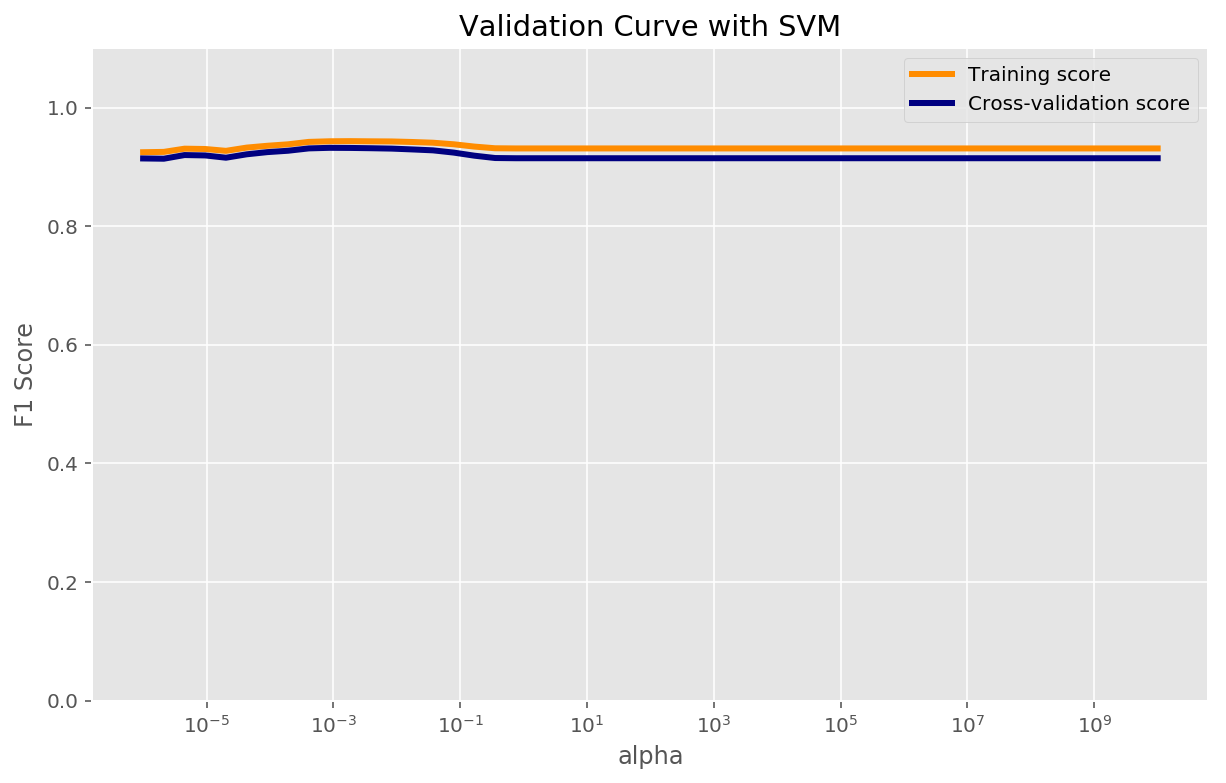

In [109]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("Validation Curve with SVM")
plt.xlabel("alpha")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
lw = 3
plt.semilogx(params['alpha'], train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.semilogx(params['alpha'], test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [252]:
grid.best_estimator_

SGDClassifier(alpha=0.0004094915062380423, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

#### Saving the best estimator

In [253]:
joblib.dump(grid.best_estimator_, 'avgW2V_best.model')

['avgW2V_best.model']

## TFIDF Word2Vec

### Loading the data

In [113]:
Dtain_tfidf_w2v = pd.read_csv('TFIDF_w2v_train.csv')
Dtest_tfidf_w2v = pd.read_csv('TFIDF_w2v_test.csv')

### Scaling the data

In [114]:
yTrain_TFIDF_w2v = Dtain_tfidf_w2v.Label
yTest_TFIDF_w2v = Dtest_tfidf_w2v.Label
Dtain_tfidf_w2v.drop(['Label'], inplace=True, axis=1)
Dtest_tfidf_w2v.drop(['Label'], inplace=True, axis=1)

Dtrain_scaled_TFIDF_w2v = sclr.fit_transform(Dtain_tfidf_w2v)
Dtest_scaled_TFIDF_w2v = sclr.fit_transform(Dtest_tfidf_w2v)

### RandomizedSearch

In [115]:
params = {
    'alpha': np.logspace(-6, 10, 500)
}
estimator = SGDClassifier(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

In [116]:
grid = RandomizedSearchCV(estimator=estimator,
                    param_distributions=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=8,
                    n_iter=50)

In [117]:
features = Dtrain_scaled_TFIDF_w2v
labels = yTrain_TFIDF_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

In [118]:
grid.fit(features, labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] alpha=4.0291220279513436 ........................................
[CV] alpha=4.0291220279513436 ........................................
[CV] alpha=4.0291220279513436 ........................................
[CV] alpha=4.0291220279513436 ........................................
[CV] ......................... alpha=4.0291220279513436, total=   1.5s
[CV] alpha=4.0291220279513436 ........................................
[CV] alpha=0.5488819609789666 ........................................
[CV] ......................... alpha=4.0291220279513436, total=   1.8s
[CV] alpha=0.5488819609789666 ........................................
[CV] ......................... alpha=4.0291220279513436, total=   2.0s
[CV] alpha=0.5488819609789666 ........................................
[CV] alpha=0.5488819609789666 ........................................
[CV] ......................... alpha=4.0291220279513436, total=   2.1s
[CV] alpha=0.54

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   17.3s


[CV] .......................... alpha=133737.2858212492, total=   3.3s
[CV] alpha=241415.71161030128 ........................................
[CV] .......................... alpha=133737.2858212492, total=   2.7s
[CV] alpha=241415.71161030128 ........................................
[CV] .......................... alpha=133737.2858212492, total=   3.6s
[CV] alpha=241415.71161030128 ........................................
[CV] ......................... alpha=241415.71161030128, total=   2.3s
[CV] alpha=241415.71161030128 ........................................
[CV] .......................... alpha=133737.2858212492, total=   4.0s
[CV] alpha=1186.1737164524743 ........................................
[CV] ......................... alpha=241415.71161030128, total=   2.7s
[CV] ......................... alpha=241415.71161030128, total=   2.4s
[CV] alpha=1186.1737164524743 ........................................
[CV] alpha=1186.1737164524743 ........................................
[CV] a

[CV] ..................... alpha=4.3780686290381665e-06, total=   2.2s
[CV] alpha=4.3780686290381665e-06 ....................................
[CV] alpha=0.014734543096198344 ......................................
[CV] ..................... alpha=4.3780686290381665e-06, total=   2.4s
[CV] .......................... alpha=338.1100782480682, total=   3.6s
[CV] alpha=0.014734543096198344 ......................................
[CV] alpha=0.014734543096198344 ......................................
[CV] ..................... alpha=4.3780686290381665e-06, total=   3.0s
[CV] ....................... alpha=0.014734543096198344, total=   1.9s
[CV] alpha=0.014734543096198344 ......................................
[CV] alpha=0.014734543096198344 ......................................
[CV] ..................... alpha=4.3780686290381665e-06, total=   3.3s
[CV] alpha=6480.719826311958 .........................................
[CV] alpha=6480.719826311958 .........................................
[CV] .

[CV] alpha=0.00016308906755493327 ....................................
[CV] ......................... alpha=1374.9172258064148, total=   2.7s
[CV] alpha=0.00016308906755493327 ....................................
[CV] ..................... alpha=0.00016308906755493327, total=   2.3s
[CV] alpha=0.00016308906755493327 ....................................
[CV] alpha=3590.1303770070613 ........................................
[CV] ......................... alpha=1374.9172258064148, total=   3.7s
[CV] ..................... alpha=0.00016308906755493327, total=   2.7s


[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  1.6min


[CV] ......................... alpha=1374.9172258064148, total=   3.7s
[CV] alpha=3590.1303770070613 ........................................
[CV] alpha=3590.1303770070613 ........................................
[CV] ..................... alpha=0.00016308906755493327, total=   3.1s
[CV] ......................... alpha=3590.1303770070613, total=   2.1s
[CV] alpha=3590.1303770070613 ........................................
[CV] ..................... alpha=0.00016308906755493327, total=   3.2s
[CV] alpha=3590.1303770070613 ........................................
[CV] alpha=1830311675.6206093 ........................................
[CV] ..................... alpha=0.00016308906755493327, total=   3.7s
[CV] ......................... alpha=3590.1303770070613, total=   2.7s
[CV] alpha=1830311675.6206093 ........................................
[CV] ......................... alpha=3590.1303770070613, total=   2.8s
[CV] alpha=1830311675.6206093 ........................................
[CV] a

[CV] ...................... alpha=3.460016392185109e-05, total=   2.1s
[CV] alpha=3.460016392185109e-05 .....................................
[CV] alpha=0.021313624718414376 ......................................
[CV] ...................... alpha=3.460016392185109e-05, total=   2.8s
[CV] .......................... alpha=11222773.56208505, total=   3.8s
[CV] alpha=0.021313624718414376 ......................................
[CV] ...................... alpha=3.460016392185109e-05, total=   3.0s
[CV] alpha=0.021313624718414376 ......................................
[CV] ....................... alpha=0.021313624718414376, total=   1.9s
[CV] alpha=0.021313624718414376 ......................................
[CV] ...................... alpha=3.460016392185109e-05, total=   3.4s
[CV] alpha=0.021313624718414376 ......................................
[CV] ...................... alpha=3.460016392185109e-05, total=   3.2s
[CV] alpha=0.00012138592626906277 ....................................
[CV] a

[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:  2.7min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          error_score='raise',
          estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=8,
          param_distributions={'alpha': array([1.00000e-06, 1.07662e-06, ..., 9.28829e+09, 1.00000e+10])},
          pre_dispatch='2*n_jobs', random_state=None, refit='f1',
          return_train_score=True,
          scoring={'f1', 'recall', 'accuracy', 'precision'}, verbose=2)

### Interpretation

In [119]:
get_summary_randomized(grid).sort_values('test_f1', ascending=False).head()

,train_f1,test_f1,train_recall,test_recall,train_accuracy,test_accuracy,train_precision,test_precision,fit_time,score_time,alpha
49,0.943036,0.931961,0.976056,0.971836,0.897326,0.880508,0.912216,0.895291,2.596760,0.141433,0.000294
37,0.943315,0.931791,0.982450,0.978152,0.897192,0.879407,0.907182,0.889635,2.820079,0.095450,0.001112
33,0.943206,0.931466,0.984453,0.980233,0.896782,0.878545,0.905281,0.887335,3.202836,0.116591,0.001864
26,0.942509,0.930729,0.985824,0.981933,0.895289,0.876926,0.902844,0.884612,2.668441,0.111773,0.003366
29,0.941855,0.930409,0.972302,0.967606,0.895451,0.878089,0.913335,0.896096,2.903936,0.102302,0.000163


In [120]:
alphas = grid.cv_results_['param_alpha'].data

In [121]:
train_scores, test_scores = validation_curve(
    estimator, features, labels, param_name="alpha", param_range=alphas,
    cv=tscv, scoring="f1", n_jobs=8)

In [122]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

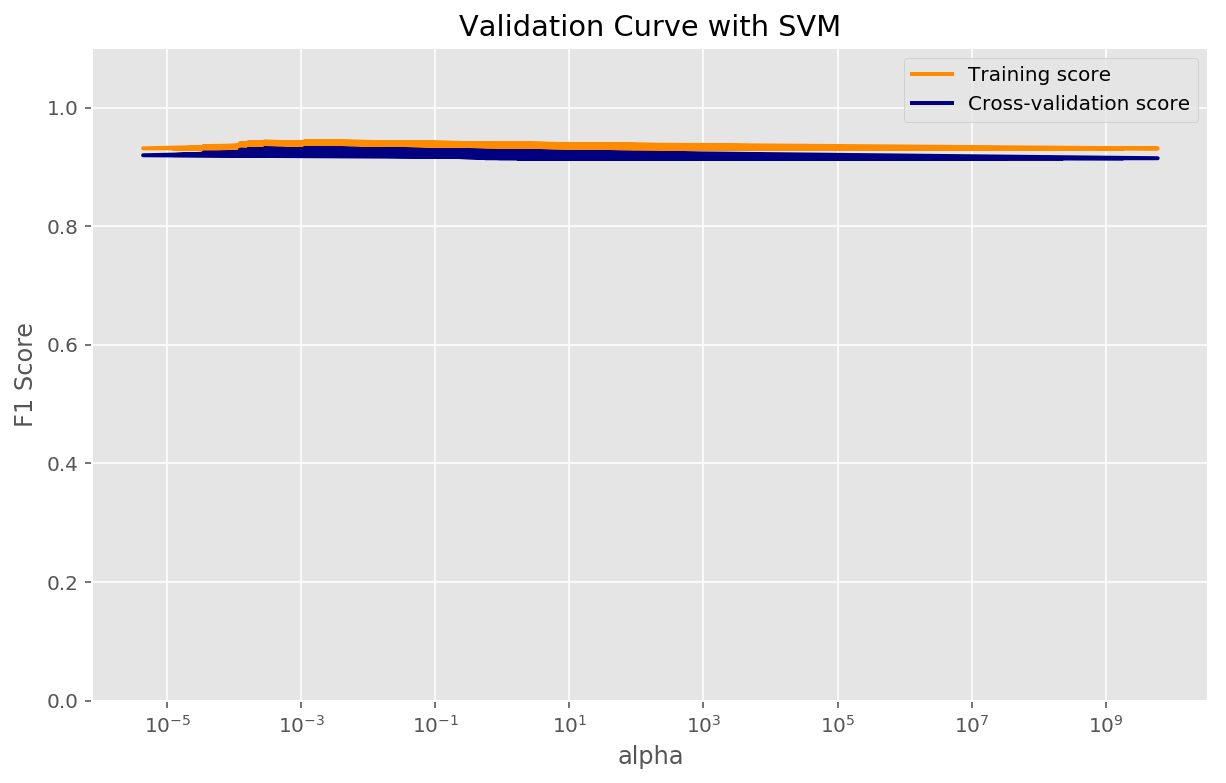

In [123]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("Validation Curve with SVM")
plt.xlabel("alpha")
plt.ylabel("F1 Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(alphas, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.semilogx(alphas, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [124]:
grid.best_estimator_

SGDClassifier(alpha=0.00029440004751000336, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

### Saving the best estimator

In [125]:
joblib.dump(grid.best_estimator_, 'tfidfW2V_best.model')

['tfidfW2V_best.model']

In [152]:
!ls *.model

avgW2V_best.model  countVectorizer.model  tfidfW2V_best.model
bog_best.model	   tfidf_best.model
bow_best.model	   tfidfVectorizer.model


## Reporting Evaluation metrics for best estimator accoring to F1 score

In [254]:
clf_bow = joblib.load('bow_best.model')
clf_tfidf = joblib.load('tfidf_best.model')
clf_avg_w2v = joblib.load('avgW2V_best.model')
clf_tfidf_w2v = joblib.load('tfidfW2V_best.model')

In [255]:
xTest_bow = Dtest_scaled_bow
actuals_bow = yTest_bow.apply(lambda x: 1 if x == 'positive' else 0).values

xTest_tfidf = Dtest_scaled_tfidf
actuals_tfidf = yTest_tfidf.apply(lambda x: 1 if x == 'positive' else 0).values

xTest_avg_w2v = Dtest_scaled_avg_w2v
actuals_avg_w2v = yTest_avg_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

xTest_tfidf_w2v = Dtest_scaled_TFIDF_w2v
actuals_tfidf_w2v = yTest_TFIDF_w2v.apply(lambda x: 1 if x == 'positive' else 0).values

In [256]:
preds_bow = clf_bow.predict(xTest_bow)
preds_tfidf = clf_tfidf.predict(xTest_tfidf)
preds_avg_w2v = clf_avg_w2v.predict(xTest_avg_w2v)
preds_tfidf_w2v = clf_tfidf_w2v.predict(xTest_tfidf_w2v)

In [257]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [258]:
acs_bow = accuracy_score(actuals_bow, preds_bow)
acs_tfidf = accuracy_score(actuals_tfidf, preds_tfidf)
acs_avg_w2v = accuracy_score(actuals_avg_w2v, preds_avg_w2v)
acs_tfidf_w2v = accuracy_score(actuals_tfidf_w2v, preds_tfidf_w2v)


pre_bow = precision_score(actuals_bow, preds_bow)
pre_tfidf = precision_score(actuals_tfidf, preds_tfidf)
pre_avg_w2v = precision_score(actuals_avg_w2v, preds_avg_w2v)
pre_tfidf_w2v = precision_score(actuals_tfidf_w2v, preds_tfidf_w2v)


rec_bow = recall_score(actuals_bow, preds_bow)
rec_tfidf = recall_score(actuals_tfidf, preds_tfidf)
rec_avg_w2v = recall_score(actuals_avg_w2v, preds_avg_w2v)
rec_tfidf_w2v = recall_score(actuals_tfidf_w2v, preds_tfidf_w2v)


f1_bow = f1_score(actuals_bow, preds_bow)
f1_tfidf = f1_score(actuals_tfidf, preds_tfidf)
f1_avg_w2v = f1_score(actuals_avg_w2v, preds_avg_w2v)
f1_tfidf_w2v = f1_score(actuals_tfidf_w2v, preds_tfidf_w2v)

from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Vectorization', 'Accuracy', 'Precision', 'Recall', 'F1']
x.add_row(['BOW', acs_bow, pre_bow, rec_bow, f1_bow])
x.add_row(['TFIDF', acs_tfidf, pre_tfidf, rec_tfidf, f1_tfidf])
x.add_row(['Avg. W2V', acs_avg_w2v, pre_avg_w2v, rec_avg_w2v, f1_avg_w2v])
x.add_row(['TFIDF W2V', acs_tfidf_w2v, pre_tfidf_w2v, rec_tfidf_w2v, f1_tfidf_w2v])
print(x)

+---------------+--------------------+--------------------+--------------------+--------------------+
| Vectorization |      Accuracy      |     Precision      |       Recall       |         F1         |
+---------------+--------------------+--------------------+--------------------+--------------------+
|      BOW      | 0.8915101248672599 | 0.9007912542352062 | 0.9760536823425022 | 0.9369134376347463 |
|     TFIDF     | 0.8870152696913105 | 0.8976798855273916 | 0.9741459627329192 | 0.9343510638297873 |
|    Avg. W2V   | 0.8634699183419385 | 0.8699102252726182 | 0.9813206437944384 |  0.92226299439151  |
|   TFIDF W2V   | 0.8733659233219818 | 0.8832325707514009 | 0.9755304870608854 | 0.9270899766506612 |
+---------------+--------------------+--------------------+--------------------+--------------------+


In [261]:
from sklearn.metrics import confusion_matrix

In [264]:
cm_bow = pd.DataFrame(confusion_matrix(actuals_bow, preds_bow),
             columns=['negative', 'positive'], index=['negative', 'positive'])

cm_tfidf = pd.DataFrame(confusion_matrix(actuals_tfidf, preds_tfidf),
             columns=['negative', 'positive'], index=['negative', 'positive'])

cm_avg_w2v = pd.DataFrame(confusion_matrix(actuals_avg_w2v, preds_avg_w2v),
             columns=['negative', 'positive'], index=['negative', 'positive'])

cm_tfidf_w2v = pd.DataFrame(confusion_matrix(actuals_tfidf_w2v, preds_tfidf_w2v),
             columns=['negative', 'positive'], index=['negative', 'positive'])

#### Bag Of Words

In [265]:
cm_bow

,negative,positive
negative,9384,9692
positive,2159,88001


#### TFIDF

In [266]:
cm_tfidf

,negative,positive
negative,9065,10011
positive,2331,87829


#### Avg, W2V

In [267]:
cm_avg_w2v

,negative,positive
negative,5853,13230
positive,1684,88469


#### TFIDF W2V

In [268]:
cm_tfidf_w2v

,negative,positive
negative,7456,11627
positive,2206,87947
